(choosing-alpha)=
# Prior information about Specificity and Sensitivity

In this notebook, we will consider the bivariate beta distribution explained
previously to jointly model sensitivity and specificity. If $\gamma_s$ and
$\gamma_e$ are, respectively sensitivity and specificity, we will have that

$$(\gamma_s, \gamma_e) \sim \operatorname{Bivariate Beta}(\alpha_1, \dots,
\alpha_4).$$

Suppose we have prior knowledge about these parameters and we want to use this
information to help to parametrize the marginal beta distributions. Here I
present some consequences of it. 

In [1]:
import pandas as pd 
import numpy as np
import pystan as ps

from scipy.stats import beta
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

import sys
sys.path.append('../scripts/')

from utilits import ParameterAlpha

Below we can see the the function that calculates the moments of the
distribution we showed last [chapter](moments-summary).

In [2]:
def moments_calculus(alpha): 
    
    tilde_alpha = alpha[0]+alpha[1]+alpha[2]+alpha[3]
    
    E_X = (alpha[0]+alpha[1])/tilde_alpha
    E_Y = (alpha[0]+alpha[2])/tilde_alpha
    
    Var_X = (1/(tilde_alpha*(tilde_alpha+1)))*E_X*(alpha[2] + alpha[3])
    Var_Y = (1/(tilde_alpha*(tilde_alpha+1)))*E_Y*(alpha[1] + alpha[3])
    
    den = np.log(alpha[0] + alpha[1]) + np.log(alpha[2]+alpha[3]) + np.log(alpha[0]+alpha[2]) + np.log(alpha[1]+alpha[3])
    den = np.exp(-0.5*den)
    Cor_XY = (alpha[0]*alpha[3] - alpha[1]*alpha[2])*den
    
    return (E_X, E_Y, Var_X, Var_Y, Cor_XY)

## From prior information to moments estimation 

The Bivariate Beta has four parameters and each marginal beta distribution has two parameters. We obtained that when  $m_1 = E[X], m_2 = E[Y], v_1 = Var[X],$ and $v_2 = Var[Y]$ are fixed, there is a solution if, and only if, 

\begin{equation}
  v_2  = \frac{v_1(1 - m_2)}{m_1(1-m_1)},
\end{equation}

and when the solution exists, there are infinitely many, described by the ray:

$$
\mathcal{L} = \{(1,-1,-1,1)\alpha_4 + k : \alpha_4 > 0\}, 
$$

such that $k = \left((m_1 + m_2 - 1)\tilde{\alpha}, (1-m_2)\tilde{\alpha},
(1-m_1)\tilde{\alpha}, 0\right)$ and $\tilde{\alpha} = \alpha_1 + \dots +
\alpha_4$. 

If we fix $\rho = Cor(X,Y)$, instead of fixing $Var[Y]$, the solution is
unique. Now we gonna evaluate how big the difference of $v_2$ to the value of its
inferred equation. As explained in the dissertation, we can write $\alpha_1,
\alpha_2$, and $\alpha_3$ as function of $\alpha_4$, and $\alpha_4$ as
function of $\rho$, when this is fixed. 


In [3]:
def alpha123_from_4(alpha4, m1, m2, v1): 
     
    C = (m1 - m1*m1 - v1)/v1 
    alpha1 = (m1 + m2 - 1)*C + alpha4 
    alpha2 = (1 - m2)*C - alpha4 
    alpha3 = (1 - m1)*C - alpha4 
    
    return (alpha1, alpha2, alpha3)

def find_alpha4_from_corr(m1, m2, v1, rho):
    
    exp = rho + np.sqrt((1-m1)*(1-m2)/(m1*m2))
    exp *= np.sqrt(m1*m2*(1-m1)*(1-m2))*(m1 - m1*m1 - v1)
    alpha4 = exp/v1
    
    return alpha4

def var_error(m1, m2, v1, v2): 
    
    return abs(v2 - v1*(1-m2)/(m1*(1 - m1)))/v2

Below we set the parameter $\alpha$ and calculate the respective moments. 

In [4]:
m1, m2, v1, v2, rho = moments_calculus([10, 20, 15, 8])
print(m1, m2, v1, v2, rho)

0.5660377358490566 0.4716981132075472 0.004548870693406115 0.004614796355629392 -0.3165549546879246


We already know there is no solution with these specified values. The relative
is error for $v_2$ is 

\begin{equation}
  \frac{|v_2  - \frac{v_1(1 - m_2)}{m_1(1-m_1)}|}{v_2}.
\end{equation}

In the case we are seeing, it is 


In [5]:
var_error(m1,m2,v1,v2)

1.1199999999999997

And we succeeded in finding the correct values from the functions we wrote. 

In [6]:
alpha4 = find_alpha4_from_corr(m1,m2,v1,rho)
alpha1, alpha2, alpha3 = alpha123_from_4(alpha4, m1, m2, v1)
print(alpha1, alpha2, alpha3, alpha4)

10.000000000000005 20.0 14.999999999999998 8.000000000000005


## Variance error for different studies 

Now we know that there is an error inherent to the modeling, so we would like
to see how this error happens in different areas. We consider some studies
from [this
article](https://link.springer.com/article/10.1007/s12350-018-01485-y) that
contains information about the estimated sensitivity and specificity and
95%-CI for several studies. The data is divided in: First column is the
estimated mean; Second column the lower bound; Third column the upper bound.

In [7]:
data_sens = np.array([
    [0.44, 0.37, 0.51],
    [0.54, 0.35, 0.72],
    [0.61, 0.39, 0.8], 
    [0.81,0.73,0.87],
    [0.36,0.26,0.47],
    [0.96,0.88,0.99]
])
data_spec = np.array([
    [0.98, 0.94,0.99],
    [0.98,0.89,1.0],
    [0.9, 0.6,0.98], 
    [0.46,0.34,0.58],
    [0.94,0.82,0.98],
    [0.82,0.74,0.88]
])

Remember that we want to obtain the expressions of the mean and variance for
each random variable. The ideia is to find the parameters of the beta
distribution marginals with the specific mean and approximated 95%-interval.
The procedure is minimize the quadratic difference between the interval and
the approximated one. The functions are below. 

We know that $\mu = \frac{\alpha}{\alpha + \beta}$ is the mean of the beta
distribution. Then $\beta = \frac{1 - \mu}{\mu}\alpha$. 

In [8]:
def diff_cumulative_95(alpha, a, b, mu): 
    
    bet = find_beta(alpha, mu)
    X = beta(a = alpha, b = bet)
    return (X.cdf(b) - X.cdf(a) - 0.95)**2
    
find_alpha = lambda mu, a, b: minimize(fun = diff_cumulative_95, x0 = (1,), args = (a, b, mu), bounds = [(0,np.inf)])
find_beta = lambda alpha, mu: alpha*(1 - mu)/mu
find_var = lambda alpha, bet: beta(a = alpha, b = bet).var()

Now we can apply these functions to data. In special, we calculate the error in the system of equations to determine $\alpha$. 

In [9]:
results = np.zeros((data_spec.shape[0], 5))

for i in range(data_spec.shape[0]): 
    
    m1 = data_sens[i,0]
    a1 = data_sens[i,1]
    b1 = data_sens[i,2]
    m2 = data_spec[i,0]
    a2 = data_spec[i,1]
    b2 = data_spec[i,2]
    
    alpha1 = find_alpha(m1, a1, b1).x[0]
    beta1 = find_beta(alpha1, m1)
    v1 = find_var(alpha1, beta1)
    
    alpha2 = find_alpha(m2, a2, b2).x[0]
    beta2 = find_beta(alpha2, m2)
    v2 = find_var(alpha2, beta2)
    
    results[i,:] = [m1,m2,v1,v2, var_error(m1,m2,v1,v2)]

Below we observe that the error is not that big for these studies. 

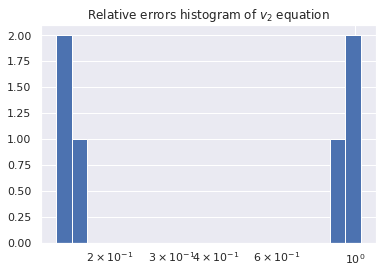

In [10]:
x = results[:,4]
hist, bins = np.histogram(x, bins=20)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.hist(x, bins=logbins)
plt.xscale('log')
plt.title(r'Relative errors histogram of $v_2$ equation')
plt.show()

## Optimizing the choice of parameters $\alpha$ 

We saw before that the system with 5 equations has a solution iff $v_2$ relates to a function of $m_1, m_2$, and $v_1$. This means that usually we will not find values for $\alpha$ that satisfies the knowledge of the input. To overcome this problem, we can minimize the sum of differences of the equations. Let $g  : \mathbb{R} \times \mathbb{R} \to \mathbb{R}$ be a loss function. Than, we want to minimize: 

$$
    g\left(m_1, \dfrac{\alpha_1+\alpha_2}{\tilde{\alpha}}\right) + 
    g\left(m_2, \dfrac{\alpha_1+\alpha_3}{\tilde{\alpha}}\right) +  
    g\left(v_1, \dfrac{(\alpha_1+\alpha_2)(\alpha_3+\alpha_4)}{\tilde{\alpha}^2(\tilde{\alpha}+1)}\right) + 
    g\left(v_2, \dfrac{(\alpha_1+\alpha_3)(\alpha_2+\alpha_4)}{\tilde{\alpha}^2(\tilde{\alpha}+1)}\right) + 
    g\left(\rho, \frac{\alpha_1\alpha_4 - \alpha_2\alpha_3}{\sqrt{(\alpha_1+\alpha_2)(\alpha_3+\alpha_4)(\alpha_1+\alpha_3 (\alpha_2+\alpha_4)}}\right)
$$

such that $\alpha_1, \dots, \alpha_4 > 0$. For instance, we can use the quadratic loss, the absolute loss, or other one. Since $m_i$ is much higher than $v_i$ ($i=1,2$) usually, one can think about a relative loss.  

Here we will use $g(x,y) = (x - y)^2/x^2$. We also add a vetor parameter $c$
of dimension four to have a weighted version. 

In [11]:
g = lambda x,y: (x - y)**2/x**2

def loss_function(alpha, m1, m2, v1, v2, rho, g, c = [1,1,1,1]): 
    
    alpha_tilde = sum(alpha)
    div = alpha_tilde*alpha_tilde*(alpha_tilde + 1)
    
    alpha_12 = alpha[0] + alpha[1]
    alpha_34 = alpha[2] + alpha[3]
    alpha_13 = alpha[0] + alpha[2]
    alpha_24 = alpha[1] + alpha[3]
    
    obj  = c[0]*g(m1, alpha_12/alpha_tilde)
    obj += c[1]*g(m2, alpha_13/alpha_tilde)
    obj += c[2]*g(v1, alpha_12*alpha_34/div)
    obj += c[3]*g(v2, alpha_13*alpha_24/div)
    obj += g(rho, (alpha[0]*alpha[3] - alpha[1]*alpha[2])/(np.sqrt(alpha_12*alpha_34*alpha_13*alpha_24)))
    
    return obj

In [12]:
m1, m2, v1, v2, rho = moments_calculus([10, 20, 15, 8])

We are using the Trust Constraint algorithm. 

In [13]:
minimizer = lambda m1, m2, v1, v2, rho, g: minimize(fun = loss_function, 
                                                 x0 = (1, 1, 1, 1), 
                                                 args = (m1, m2, v1, v2, rho, g),
                                                 bounds = [(0, np.inf)]*4,
                                                 method = 'trust-constr')

Therefore we can obtain very similar values for the parameters. 

In [14]:
minimizer(m1,m2,v1,v2,rho, g).x

array([ 9.99999839, 19.99999852, 15.0000007 ,  8.00000127])

### Some remarks

Sometimes the initial guess $x_0$ is very important as we can see below: 

In [15]:
m1, m2, v1, v2, rho = moments_calculus([1, 1, 2, 20])

minimizer = lambda m1, m2, v1, v2, rho, g, x0: minimize(fun = loss_function, 
                                                 x0 = x0, 
                                                 args = (m1, m2, v1, v2, rho, g),
                                                 bounds = [(0, np.inf)]*4,
                                                 method = 'trust-constr')

print(r'The $\alpha$ values for $x_0$ = [1,1,1,1] : {}'.format(minimizer(m1,m2,v1,v2,rho,g, x0 = [1,1,1,1]).x))
print(r'The $\alpha$ values for $x_0$ = [1,1,1,5] : {}'.format(minimizer(m1,m2,v1,v2,rho,g, x0 = [1,1,1,5]).x))

<ipython-input-11-31fea47f0948>:17: RuntimeWarning: invalid value encountered in sqrt
  obj += g(rho, (alpha[0]*alpha[3] - alpha[1]*alpha[2])/(np.sqrt(alpha_12*alpha_34*alpha_13*alpha_24)))


The $\alpha$ values for $x_0$ = [1,1,1,1] : [ 5.95645337  9.57916884 18.26099607 24.06254864]
The $\alpha$ values for $x_0$ = [1,1,1,5] : [ 1.00000012  1.00000012  2.00000023 20.00000114]


Other metrics can be considered:

In [16]:
m1, m2, v1, v2, rho = moments_calculus([1, 5, 6, 3])

h = lambda x,y: (x - y)**2

minimizer = lambda m1, m2, v1, v2, rho, g, c: minimize(fun = loss_function, 
                                                 x0 = [1,1,1,1], 
                                                 args = (m1, m2, v1, v2, rho, g, c),
                                                 bounds = [(0, np.inf)]*4,
                                                 method = 'trust-constr')

print(r'The $\alpha$ values for $c$ = [1,1,1,1], g = quadratic : {}'.format(minimizer(m1,m2,v1,v2,rho,h, c = [1,1,1,1]).x))
print(r'The $\alpha$ values for $c$ = [1,1,10,10], g = quadratic : {}'.format(minimizer(m1,m2,v1,v2,rho,h, c = [1,1,10,10]).x))

print(r'The $\alpha$ values for $c$ = [1,1,1,1], g = relative quadratic : {}'.format(minimizer(m1,m2,v1,v2,rho,g, c = [1,1,1,1]).x))
print(r'The $\alpha$ values for $c$ = [1,1,10,10], g = relative quadratic : {}'.format(minimizer(m1,m2,v1,v2,rho,g, c = [1,1,10,10]).x))

The $\alpha$ values for $c$ = [1,1,1,1], g = quadratic : [1.00022465 5.00111486 6.00133688 3.00066687]
The $\alpha$ values for $c$ = [1,1,10,10], g = quadratic : [1.00002614 5.00012205 6.0001456  3.00007131]
The $\alpha$ values for $c$ = [1,1,1,1], g = relative quadratic : [1.00000012 5.00000005 6.00000004 2.99999992]
The $\alpha$ values for $c$ = [1,1,10,10], g = relative quadratic : [1.0000003  4.99999993 6.00000016 2.99999976]


In order to avoid numerical instability, the weighted quadratic loss can be
useful. Other approaches consider working on the log space. 

In [17]:
m1, m2, v1, v2, rho = moments_calculus([1, 5, 30, 3])

h = lambda x,y: (x - y)**2

minimizer = lambda m1, m2, v1, v2, rho, g, c: minimize(fun = loss_function, 
                                                 x0 = [1,1,1,1], 
                                                 args = (m1, m2, v1, v2, rho, g, c),
                                                 bounds = [(0, np.inf)]*4,
                                                 method = 'trust-constr')

print(r'The $\alpha$ values for $c$ = [1,1,1,1], g = quadratic : {}'.format(minimizer(m1,m2,v1,v2,rho,h, c = [1,1,1,1]).x))
print(r'The $\alpha$ values for $c$ = [1,1,10,10], g = quadratic : {}'.format(minimizer(m1,m2,v1,v2,rho,h, c = [1,1,10,10]).x))

print(r'The $\alpha$ values for $c$ = [1,1,1,1], g = relative quadratic : {}'.format(minimizer(m1,m2,v1,v2,rho,g, c = [1,1,1,1]).x))
print(r'The $\alpha$ values for $c$ = [1,1,10,10], g = relative quadratic : {}'.format(minimizer(m1,m2,v1,v2,rho,g, c = [1,1,10,10]).x))

The $\alpha$ values for $c$ = [1,1,1,1], g = quadratic : [ 0.99980935  4.99903699 29.99420193  2.99941945]
The $\alpha$ values for $c$ = [1,1,10,10], g = quadratic : [ 1.00005621  5.00024359 30.0014424   3.00013576]


<ipython-input-11-31fea47f0948>:17: RuntimeWarning: invalid value encountered in sqrt
  obj += g(rho, (alpha[0]*alpha[3] - alpha[1]*alpha[2])/(np.sqrt(alpha_12*alpha_34*alpha_13*alpha_24)))


The $\alpha$ values for $c$ = [1,1,1,1], g = relative quadratic : [12.0611353  12.51811669 15.80903826 15.22546947]
The $\alpha$ values for $c$ = [1,1,10,10], g = relative quadratic : [ 1.00000053  4.99999876 29.99999809  3.00000013]


/home/lucasmoschen/anaconda3/envs/tcc-emap/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


## Mixing method to choose $\alpha$

The true solution to the system to find $\alpha$ commonly has negative values. So the optimizer has a fight between the barrier in 0 and the function being smaller for small values. It leads to very small values and spoils the sampling from Dirichlet distribution. In that sense, we develop a mixing method that choose $\alpha$ in order to have the means of sensibility and specificity fixed, while the other parameters are left to be optimized. This is done, because we believe that information about means may be more precise that variance. Moreover, its values are commonly larger. 

In [13]:
alpha_hat = ParameterAlpha().mix_solver(m1, m2, v1, v2, rho)
alpha_hat

(10.188786462232764, 20.37725115580932, 15.282911552802306, 8.15105062102996)

Note that these values are different from what we put. However look below: 

In [14]:
ParameterAlpha().partial_loss_function(alpha_hat[2:], m1, m2, v1, v2, rho, g = ParameterAlpha().quadratic_error, c = (1,1))

6.453527824846111e-11

In [15]:
ParameterAlpha().partial_loss_function([15,8], m1, m2, v1, v2, rho, g = ParameterAlpha().quadratic_error, c = (1,1))

2.000000000000014

It says that our loss function produces an error of 2 for the correct values! Despite that, they produce very similar values of $m_1, m_2, v_1, v_2$ and $\rho$. 

In [16]:
v = moments_calculus(alpha_hat)
np.array(v) - np.array([m1,m2,v1,v2,rho])

array([ 0.00000000e+00,  0.00000000e+00, -8.27067230e-05, -8.39053711e-05,
        8.02799138e-06])

This behaviour happens because we made some simplifications to the minimizer assuming the first two equations correct. In special, we are minimizing (for quadratic error): 

$$
\left(\tilde{a} - \frac{m_1(1 - m_1)}{v_1}\right)^2 + \left(\tilde{a} - \frac{m_2(1 - m_2)}{v_2}\right)^2 + \left(\rho - \frac{\alpha_1\alpha_4 - \alpha_2\alpha_3}{\tilde{\alpha}^2\sqrt{m_1m_2(1 - m_1)(1 - m_2)}}\right)^2
$$

Consider now the following information which will be useful afterwards. The ideia is that these values are similar to what we expect in real life for sensibility and specificity. 

In [17]:
m1, m2, v1, v2, rho = 0.9, 0.9, 0.01, 0.01, -0.3

In [30]:
alpha_hat = ParameterAlpha().mix_solver(m1, m2, v1, v2, rho, lb = 0.001)
tuple(alpha_hat)

(7.201013156990748,
 0.8989985761829642,
 0.8989985761829642,
 0.0010027275030035426)

In [32]:
alpha_hat_2 = ParameterAlpha().minimizer(m1, m2, v1, v2, rho)
tuple(alpha_hat_2.x)

(8.645046339762947,
 2.2171031119350904,
 2.2171031019177856,
 9.809568232079225e-08)

Note that the algorithms produce different results, but 

In [33]:
print(moments_calculus(alpha_hat))
print(moments_calculus(alpha_hat_2.x))

(0.8999999999999999, 0.8999999999999999, 0.008999988266841579, 0.008999988266841579, -0.10987317771541383)
(0.8304870118306533, 0.8304870110647606, 0.009998992027047132, 0.009998992063003248, -0.20411269769507853)


Both algorithms outperformed $\rho$ parameter. It happens because this system has solution $\alpha_4 < 0$. In that case, $\rho$ can be even smaller and reaches the correct answer. 

In [21]:
ParameterAlpha().solve_equations(m1, m2, v1, v2, rho)

Exception: This system does not have a solution since alpha_4 < 0